# Task 1

In [4]:
# Import libraries
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
r = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt')
''' Note that this list is the top 200 only if the whole list is sorted
    This check is done at the end, after the dataframe has been created (see below).
    Moreover, this code would work for any 'top k' '''  
data = r.json()['data'][:200]

In [ ]:
df = pd.DataFrame(columns=['Rank', 'Country', 'Region', 'Total Faculty Members',
                           'International Faculty Members', 'Total Students', 
                           'International Students'])
df.index.name = 'Name'

'''Get a single number from the details webpage. ClassName is the information on the webpage
   to be returned.'''
def getCount(details, className):
        attr = BeautifulSoup(details.text, 'html.parser').find('div', class_=className)
        if attr is None:
            print ("No attribute '", className, "' found")
            return None
        return int(attr.find('div', class_="number").text.strip().replace(',', ''))

'Dataframe generation'    
for d in data:
    soup = BeautifulSoup(d['uni'], 'html.parser')
    details = requests.get("https://www.topuniversities.com" + soup.a.get('href'))
    index = soup.a.text.strip()
    print("Processing", d['overall_rank'], ":", index)
    df.loc[index] = [int(d['overall_rank']), d['location'], d['region'], 
                     getCount(details, 'total faculty'), 
                     getCount(details, 'inter faculty'),
                     getCount(details, 'total student'),
                     getCount(details, 'total inter')]

In [7]:
df.index.is_unique

True

In [8]:
'Check that the dataframe has the correct length'
len(df)

200

In [9]:
'Now we can check for rank correctness'
# There is no built-in method
def checkSorted(df):
    col = df['Rank']
    for i in range(len(col) - 1):
        if col[i + 1] < col[i] or col[i] > len(col):
            print("The list is not correct:")
            print(df.iloc[i], "\n")
            print(df.iloc[i + 1])
            return False
    return col[len(col) - 1] <= len(col)

checkSorted(df)

The list is not correct:
Rank                                 281
Country                          Germany
Region                            Europe
Total Faculty Members               4913
International Faculty Members        669
Total Students                     34029
International Students              4929
Name: Technische Universität Dresden, dtype: object 

Rank                                       195
Country                          United States
Region                           North America
Total Faculty Members                     3446
International Faculty Members              206
Total Students                           60294
International Students                    4900
Name: Texas A&M University, dtype: object


False

In [10]:
 ''' As of 20/10/2017, in the potential 'top 200' the University of Dresden has rank 281.
 However, we suspect it is wrong: there is no university with rank 198 (there are 3 universities with 
 rank 195 and one with 199) and there are two universities with rank 281, including the University of Dresden.
 However, rank 282 is filled and all the ranks afterwards are correct. This leads us to believe that one of the 
 two universities with rank 281 should have rank 198 or 195. Since the University of Dresden is indexed among 
 the universities of rank 195, the simplest way to restore ordering in the university list is to assign rank 195
 to the university of Dresden.'''

df.loc['Technische Universität Dresden', 'Rank'] = 195
checkSorted(df)

True

In [11]:
df

,Rank,Country,Region,Total Faculty Members,International Faculty Members,Total Students,International Students
Name,,,,,,,
Massachusetts Institute of Technology (MIT),1,United States,North America,2982,1679,11067,3717
Stanford University,2,United States,North America,4285,2042,15878,3611
Harvard University,3,United States,North America,4350,1311,22429,5266
California Institute of Technology (Caltech),4,United States,North America,953,350,2255,647
University of Cambridge,5,United Kingdom,Europe,5490,2278,18770,6699
University of Oxford,6,United Kingdom,Europe,6750,2964,19720,7353
UCL (University College London),7,United Kingdom,Europe,6345,2554,31080,14854
Imperial College London,8,United Kingdom,Europe,3930,2071,16090,8746
University of Chicago,9,United States,North America,2449,635,13557,3379


Our strategy to select the "best" universities according to the criteria is to take the top 5% of the 200 universities (hence the top 10). On the other hand, we do not impose this restriction when grouping by countries or regions. 

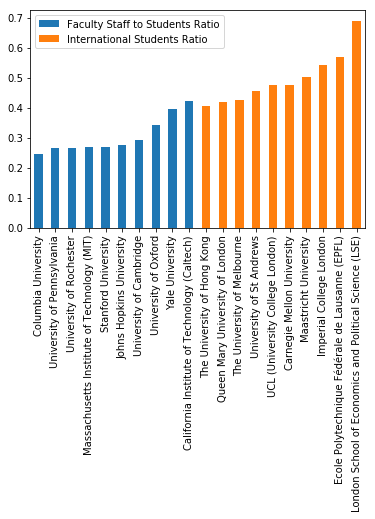

In [384]:
# Best universities by ratio of faculty members / students

def bestRatios(ratios):
    ratios = ratios.sort_values(ascending=False)
    return ratios[:10]

def plotUnis(df):
    res1 = bestRatios(df['International Students'] / df['Total Students'])
    res2 = bestRatios(df['Total Faculty Members'] / df['Total Students'])
    plotDF = pd.DataFrame({'International Students Ratio' : res1, 'Faculty Staff to Students Ratio' : res2})
    plt.figure(figsize=(20,10))
    plotDF.sort_values(['Faculty Staff to Students Ratio', 'International Students Ratio']).plot(kind='bar', stacked=True)

plotUnis(df)

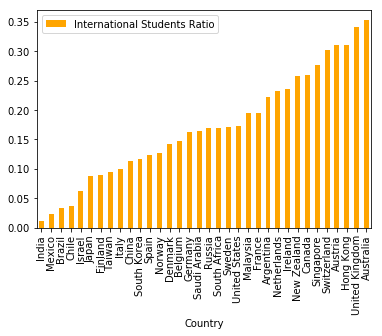

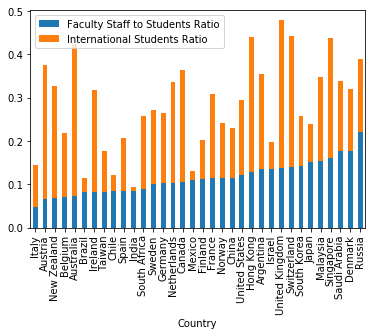

In [424]:
# Best university groups according to the ratio of 2 given attributes 
def groupRatios(df, column, numerator, denominator):
    groups = df.groupby(column)
    return (groups[numerator].sum() / groups[denominator].sum())

def plotGroups(df, by):

    res1 = groupRatios(df, by, 'International Students', 'Total Students')
    res2 = groupRatios(df, by, 'Total Faculty Members', 'Total Students')
    plotDF = pd.DataFrame({'International Students Ratio' : res1, 'Faculty Staff to Students Ratio' : res2})
    plotDF = plotDF.sort_values('Faculty Staff to Students Ratio')
    plotDF['International Students Ratio'].sort_values().plot.bar(color='orange', legend=True)
    #plotDF['Faculty Staff to Students Ratio'].plot.bar(color='b', alpha=0.5, legend=True)
    plotDF.plot(kind='bar', stacked=True)

plotGroups(df, 'Country')

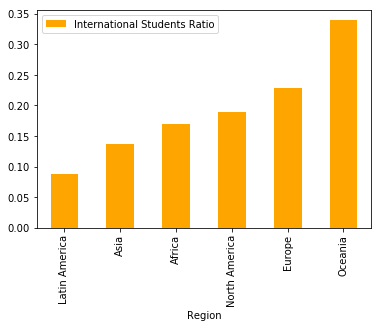

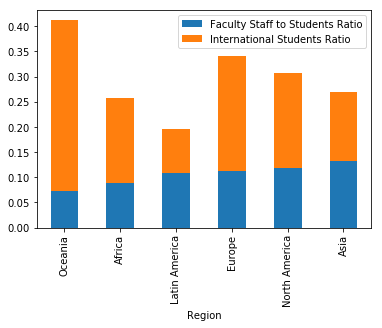

In [425]:
plotGroups(df, 'Region')

# Task 2

In [18]:
r2 = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
''' Note that this list is the top 200 only if the whole list is sorted
    This check is done at the end, after the dataframe has been created (see below).
    Moreover, this code would work for any 'top k' '''  
data2 = r2.json()['data'][:200]

In [ ]:
df2 = pd.DataFrame(columns=['Rank', 'Country', 'Total Faculty Members',
                           'International Faculty Members', 'Total Students', 
                           'International Students', 'Ratio Faculty to Student', 'Ratio Intl Students'])
df2.index.name = 'Name'

'Dataframe generation'    
for d in data2:
    index = d['name']
    rank = int(d['rank'].strip("="))
    print("Processing", rank, ":", index)
    num_students = int(d['stats_number_students'].replace(",", ""))
    num_faculty = round(num_students / float(d['stats_student_staff_ratio']))
    ratio_faculty_student= 1 / float(d['stats_student_staff_ratio'])    
    ratio_intl_student = float(d['stats_pc_intl_students'].strip("%")) / 100
    num_intl_students = round(ratio_intl_student * num_students)
    df2.loc[index] = [rank, d['location'], num_faculty, 
                      '?', num_students, num_intl_students, 
                      ratio_faculty_student, ratio_intl_student]

In [21]:
# filling up regions with previous dataset for future use
regions = df[['Country', 'Region']].drop_duplicates()
df2 = df2.reset_index().merge(regions, on='Country', how='left').set_index('Name')

In [22]:
df2

,Rank,Country,Total Faculty Members,International Faculty Members,Total Students,International Students,Ratio Faculty to Student,Ratio Intl Students,Region
Name,,,,,,,,,
University of Oxford,1,United Kingdom,1822,?,20409,7755,0.089286,0.38,Europe
University of Cambridge,2,United Kingdom,1687,?,18389,6436,0.091743,0.35,Europe
California Institute of Technology,3,United States,340,?,2209,596,0.153846,0.27,North America
Stanford University,3,United States,2113,?,15845,3486,0.133333,0.22,North America
Massachusetts Institute of Technology,5,United States,1285,?,11177,3800,0.114943,0.34,North America
Harvard University,6,United States,2284,?,20326,5285,0.112360,0.26,North America
Princeton University,7,United States,958,?,7955,1909,0.120482,0.24,North America
Imperial College London,8,United Kingdom,1391,?,15857,8721,0.087719,0.55,Europe
University of Chicago,9,United States,2181,?,13525,3381,0.161290,0.25,North America


In [23]:
checkSorted(df2)

True

In [24]:
df2.index.is_unique

True

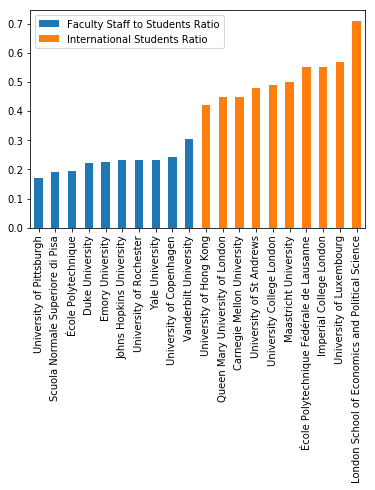

In [426]:
plotUnis(df2)

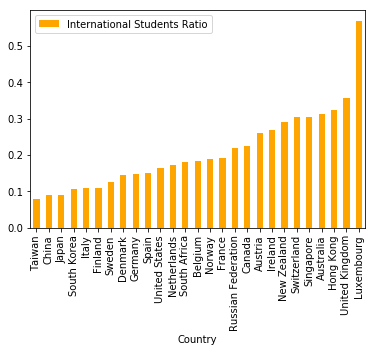

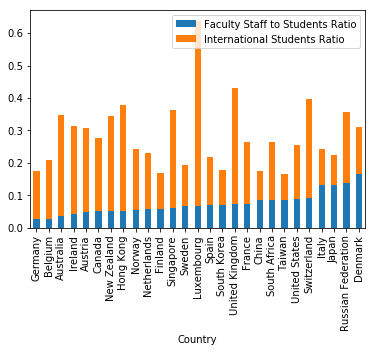

In [427]:
plotGroups(df2, 'Country')

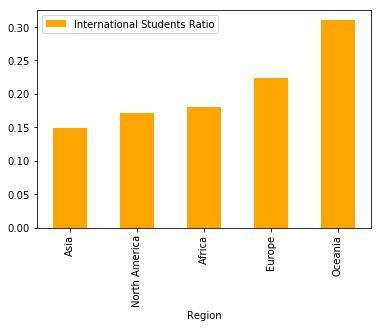

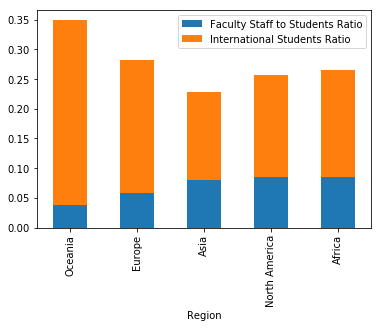

In [428]:
plotGroups(df2, 'Region')

<h1>Task 3</h1>

Merge the two DataFrames created in questions 1 and 2 using university names. 
Match universities' names as well as you can, and explain your strategy. 
Keep track of the original position in both rankings.

<h2>Strategy</h2>
the biggest concern in matching university names is that the original name and the english translation are not used consistenlty: the first website tend to use more frequently the original name, while the second use often the english version. Our approach is to use wikipedia to normalize / translate foreign university names. At first, we would navigate through the university page in the foreign language with the aim of retriving the English page link. However, this required two 'gets' requests, resulting in bad performance. Luckily, querying the english webserver of wikipedia will return the english webpage regardless of the language of the query, thus only one get request is needed. Finally, the header of the page is sufficient to retrieve the English "translation".
However, there are many cases where wikipedia fails to match the query to any English page. For this reason the next step is to pre-process, i.e. to apply standard data mining technique to improve text matching. The third and last step is to go through the universities by country and assess the quality of the matching. We found 9 edge cases overall and decided to fix them manually. Note that the final result is the perfect match of the two websites.

In [31]:
def to_english(unis):
    i = 0
    for uni in unis:
        url = 'https://en.wikipedia.org/wiki/' + uni
        soup = BeautifulSoup(requests.get(url).text, "html.parser")
        eng = soup.h1.text
        unis[i] = eng
        print(uni, "->", eng)
        i += 1
    return unis

eng = to_english(df.reset_index()['Name'])
eng2 = to_english(df2.reset_index()['Name'])

Massachusetts Institute of Technology (MIT) -> Massachusetts Institute of Technology (MIT)
Stanford University -> Stanford University
Harvard University -> Harvard University
California Institute of Technology (Caltech) -> California Institute of Technology (Caltech)
University of Cambridge -> University of Cambridge
University of Oxford -> University of Oxford
UCL (University College London) -> UCL (University College London)
Imperial College London -> Imperial College London
University of Chicago -> University of Chicago
ETH Zurich - Swiss Federal Institute of Technology -> ETH Zurich - Swiss Federal Institute of Technology
Nanyang Technological University, Singapore (NTU) -> Nanyang Technological University, Singapore (NTU)
Ecole Polytechnique Fédérale de Lausanne (EPFL) -> Ecole Polytechnique Fédérale de Lausanne (EPFL)
Princeton University -> Princeton University
Cornell University -> Cornell University
National University of Singapore (NUS) -> National University of Singapore (NU

McMaster University -> McMaster University
RWTH Aachen University -> RWTH Aachen University
University of Oslo -> University of Oslo
University of Pittsburgh -> University of Pittsburgh
Technische Universität Berlin (TU Berlin) -> Technische Universität Berlin (TU Berlin)
The Hebrew University of Jerusalem -> Hebrew University of Jerusalem
University of Lausanne -> University of Lausanne
Emory University -> Emory University
Erasmus University Rotterdam -> Erasmus University Rotterdam
Michigan State University -> Michigan State University
University of Basel -> University of Basel
University of Otago -> University of Otago
University of Waterloo -> University of Waterloo
Université catholique de Louvain (UCL) -> Université catholique de Louvain (UCL)
University of Vienna -> University of Vienna
Hanyang University -> Hanyang University
Universitat de Barcelona -> University of Barcelona
École Normale Supérieure de Lyon -> École normale supérieure de Lyon
University of Aberdeen -> Univers

Monash University -> Monash University
University of Freiburg -> University of Freiburg
University of Groningen -> University of Groningen
Michigan State University -> Michigan State University
University of New South Wales -> University of New South Wales
Rice University -> Rice University
Uppsala University -> Uppsala University
Free University of Berlin -> Free University of Berlin
Dartmouth College -> Dartmouth College
University of Helsinki -> University of Helsinki
University of Warwick -> University of Warwick
Technical University of Berlin -> Technical University of Berlin
Lund University -> Lund University
University of Tübingen -> University of Tübingen
University of Basel -> University of Basel
Korea Advanced Institute of Science and Technology (KAIST) -> Korea Advanced Institute of Science and Technology (KAIST)
Durham University -> Durham University
Emory University -> Emory University
University of California, Irvine -> University of California, Irvine
University of Bonn 

In [68]:
import unicodedata

def preProcess(ind):
    # to lower case
    ind = ind.str.lower()
    # strip brackets and their content
    ind = ind.str.replace(r"\(.*\)","")
    # strip punctuation
    ind = ind.str.replace('[^\w\s]','')
    # stem the words 'university | universitat | universität...'
    ind = ind.str.replace('univers[^ ]*', 'univers')
    # germany specific pre-processing
    ind = ind.str.replace('(technische|technical) univers', 'tu')
    # strip typical stopwords
    pat = r'\b(?:{})\b'.format('|'.join(['the', 'of']))
    ind = ind.str.replace(pat, '')
    # strip multiple whitespaces
    ind = ind.str.strip().str.replace(' +', ' ')
    # get rid of accents
    ind = ind.map(lambda x: unicodedata.normalize('NFD', x).encode('ascii', 'ignore'))
    return ind

keys = preProcess(eng)
keys2 = preProcess(eng2)
keys.index = df.index
df['Key'] = keys
keys2.index = df2.index
df2['Key'] = keys2

In [74]:
# Fixing edge cases, when the get request to wikipedia fails
df.loc['KIT, Karlsruhe Institute of Technology', "Key"] = "karlsruhe institute technology".encode()
df.loc['Université Pierre et Marie Curie (UPMC)', "Key"] = "pierre and marie curie univers".encode()
df.loc['Trinity College Dublin, The University of Dublin', "Key"] = "trinity college dublin".encode()
df.loc['Scuola Superiore Sant\'Anna Pisa di Studi Universitari e di Perfezionamento', "Key"] = "scuola superiore santanna".encode()
df.loc['Nanyang Technological University, Singapore (NTU)', "Key"] = "nanyang technological univers".encode()
df.loc['KAIST - Korea Advanced Institute of Science & Technology', "Key"] = "korea advanced institute science and technology".encode()
df2.loc['University College London', "Key"] = "ucl".encode()
df2.loc['Wageningen University & Research', "Key"] = "wageningen univers and research centre".encode()
df2.loc['ETH Zurich – Swiss Federal Institute of Technology Zurich', "Key"] = "eth zurich swiss federal institute technology".encode()
# Merging the dataframes
df3 = df.reset_index().merge(df2.reset_index(), on='Key', how='outer').set_index('Key')
# Merge fields
df3['Country'] = df3['Country_x'].fillna(df3['Country_y'])
df3['Region'] = df3['Region_x'].fillna(df3['Region_y'])
df3 = df3.drop(['Country_x', 'Country_y', 'Region_x', 'Region_y'], 1)

In [75]:
# Code used to determine the edge cases
# Find the list of not matched universities
todo = df3[(pd.isnull(df3['Rank_x'])) | (pd.isnull(df3['Rank_y'])) ]
todo.groupby('Country').size()

Country
Argentina          1
Australia          1
Austria            1
Belgium            2
Brazil             2
Canada             1
Chile              1
France             5
Germany            8
India              3
Ireland            1
Israel             1
Italy              2
Japan              7
Luxembourg         1
Malaysia           1
Mexico             2
Netherlands        3
New Zealand        1
Norway             1
Saudi Arabia       1
South Korea        3
Spain              3
Sweden             3
Taiwan             1
United Kingdom     7
United States     15
dtype: int64

In [77]:
# I checked all countries one by one to make sure no other matches are possible 
# Here is an example:
todo[todo['Country'] == 'Germany']

,Name_x,Rank_x,Total Faculty Members_x,International Faculty Members_x,Total Students_x,International Students_x,Name_y,Rank_y,Total Faculty Members_y,International Faculty Members_y,Total Students_y,International Students_y,Ratio Faculty to Student,Ratio Intl Students,Country,Region
Key,,,,,,,,,,,,,,,,
b'univers bonn',NaN,NaN,NaN,NaN,NaN,NaN,University of Bonn,100,457,?,35619,4630,0.012837,0.13,Germany,Europe
b'univers mannheim',NaN,NaN,NaN,NaN,NaN,NaN,University of Mannheim,125,148,?,10995,1759,0.013423,0.16,Germany,Europe
b'charite',NaN,NaN,NaN,NaN,NaN,NaN,Charité - Universitätsmedizin Berlin,126,419,?,6792,1223,0.061728,0.18,Germany,Europe
b'univers cologne',NaN,NaN,NaN,NaN,NaN,NaN,University of Cologne,145,886,?,45087,4509,0.019646,0.10,Germany,Europe
b'univers ulm',NaN,NaN,NaN,NaN,NaN,NaN,Ulm University,155,375,?,10657,1385,0.035211,0.13,Germany,Europe
b'univers erlangennuremberg',NaN,NaN,NaN,NaN,NaN,NaN,University of Erlangen-Nuremberg,162,662,?,38730,4648,0.017094,0.12,Germany,Europe
b'univers wurzburg',NaN,NaN,NaN,NaN,NaN,NaN,University of Würzburg,165,665,?,22537,2028,0.029499,0.09,Germany,Europe
b'univers munster',NaN,NaN,NaN,NaN,NaN,NaN,University of Münster,173,993,?,42287,2960,0.023474,0.07,Germany,Europe


In [78]:
# We can now get rid of unmatchable cases...
df4 = df3[(pd.notnull(df3['Rank_x'])) & (pd.notnull(df3['Rank_y']))]
# ...and merge the indexes
df4.index = df4["Name_y"]
df4.index.name = "Name"
df4 = df4.drop(["Name_x", "Name_y"], axis=1)
df4

,Rank_x,Total Faculty Members_x,International Faculty Members_x,Total Students_x,International Students_x,Rank_y,Total Faculty Members_y,International Faculty Members_y,Total Students_y,International Students_y,Ratio Faculty to Student,Ratio Intl Students,Country,Region
Name,,,,,,,,,,,,,,
Massachusetts Institute of Technology,1,2982,1679,11067,3717,5,1285,?,11177,3800,0.114943,0.34,United States,North America
Stanford University,2,4285,2042,15878,3611,3,2113,?,15845,3486,0.133333,0.22,United States,North America
Harvard University,3,4350,1311,22429,5266,6,2284,?,20326,5285,0.112360,0.26,United States,North America
California Institute of Technology,4,953,350,2255,647,3,340,?,2209,596,0.153846,0.27,United States,North America
University of Cambridge,5,5490,2278,18770,6699,2,1687,?,18389,6436,0.091743,0.35,United Kingdom,Europe
University of Oxford,6,6750,2964,19720,7353,1,1822,?,20409,7755,0.089286,0.38,United Kingdom,Europe
University College London,7,6345,2554,31080,14854,16,2886,?,30304,14849,0.095238,0.49,United Kingdom,Europe
Imperial College London,8,3930,2071,16090,8746,8,1391,?,15857,8721,0.087719,0.55,United Kingdom,Europe
University of Chicago,9,2449,635,13557,3379,9,2181,?,13525,3381,0.161290,0.25,United States,North America


# Task 4

In [98]:
df4_f = df4.drop(['International Faculty Members_y', 'Country', 'Region'], axis=1)
df4_f['Ratio Faculty to Students_y'] = df4_f['Ratio Faculty to Student']
df4_f['Ratio Intl Students_y'] = df4_f['Ratio Intl Students']
df4_f['Ratio Faculty to Students_x'] = df4_f['Total Faculty Members_x'] / df4_f['Total Students_x']
df4_f['Ratio Intl Students_x'] = df4_f['International Students_x'] / df4_f['Total Students_x']
df4_f = df4_f.drop(['Ratio Faculty to Student', 'Ratio Intl Students'], axis=1)
df4_f = df4_f.astype(float)
df4_f.corr()

,Rank_x,Total Faculty Members_x,International Faculty Members_x,Total Students_x,International Students_x,Rank_y,Total Faculty Members_y,Total Students_y,International Students_y,Ratio Faculty to Students_y,Ratio Intl Students_y,Ratio Faculty to Students_x,Ratio Intl Students_x
Rank_x,1.000000,-0.349491,-0.515319,-0.014637,-0.259089,0.694928,-0.265523,-0.018018,-0.283073,-0.229714,-0.313034,-0.396070,-0.322844
Total Faculty Members_x,-0.349491,1.000000,0.639255,0.589954,0.411004,-0.352537,0.729179,0.606312,0.389084,0.158723,-0.133603,0.339379,-0.087373
International Faculty Members_x,-0.515319,0.639255,1.000000,0.284445,0.580620,-0.363017,0.306740,0.280583,0.546327,0.022309,0.329189,0.317711,0.384385
Total Students_x,-0.014637,0.589954,0.284445,1.000000,0.625266,-0.142471,0.517444,0.982896,0.577229,-0.369828,-0.279762,-0.427263,-0.207880
International Students_x,-0.259089,0.411004,0.580620,0.625266,1.000000,-0.253608,0.189553,0.576457,0.926712,-0.329592,0.417840,-0.242740,0.529105
Rank_y,0.694928,-0.352537,-0.363017,-0.142471,-0.253608,1.000000,-0.230824,-0.145242,-0.282808,-0.122816,-0.203550,-0.300901,-0.224525
Total Faculty Members_y,-0.265523,0.729179,0.306740,0.517444,0.189553,-0.230824,1.000000,0.545624,0.212395,0.469605,-0.253511,0.174790,-0.243215
Total Students_y,-0.018018,0.606312,0.280583,0.982896,0.576457,-0.145242,0.545624,1.000000,0.558293,-0.362422,-0.305108,-0.413774,-0.239737
International Students_y,-0.283073,0.389084,0.546327,0.577229,0.926712,-0.282808,0.212395,0.558293,1.000000,-0.320113,0.511647,-0.234276,0.534429
Ratio Faculty to Students_y,-0.229714,0.158723,0.022309,-0.369828,-0.329592,-0.122816,0.469605,-0.362422,-0.320113,1.000000,-0.021779,0.691656,-0.062014


We found that there is a moderate correlation between the number of international students and international staff member according to the first website: the international dimension of the university grows uniformely. As one would expect, the academic staff grows linearly with the number of students. It is interesting to note that the figures of both websites are strongly correlated. This gives us confidence that the two information sources are consistent. On top of that, even though the two websites are arguably using different ranking metrics, their ranks are strongly correlated as well (so perhaps the indicator used are similar).
The ranks of both websites follow similar patterns: they slightly decrease as the staff grows (although the first source suggests a significant correlation with the number of staff members, while the second does not), there is little to no dependence to the number of students, but, in contrast, we observe a feeble but noticeable decrease of the ranks as the number of international students increases. Surprisingly, the ratio of professors to students does not play a big role in the rankings, this ratio's "presence" is indeed comparable to that of the ratio of international students. Trivially, the ratios of international students and faculty members to students are not correlated.

# Task 5

As mentioned previously, there is a 0.7 correlation in the top 200 universities of the two websites. This leads us to think that the two produce similar results. Yet, there are quite evident differences in the two rankings, mostly due to the different weighting and methodologies. Indeed, topuniversities.com is heavily based on reputation surveys, which determine half of the scoring. In contrast, timeshighereducation.com is more devoted to teaching quality assessment, which constitutes a third of its scoring. To sum up, the first websites gives prospective students an intuition of how employers will perceive the institutions, while the second one measures their success in the academic world. Since our aim is to select the "best" university, there is no reason to suppose that such candidate university should be better in one or the other context: it should be appealing to both readerships. We shall consider both information sources equally reliable, which entails assigning equal weights (0.5) to both ranks. The final rank is then simply the linear combination of the two ranks.

Sources (as of 22/10/2017): 
1. https://www.topuniversities.com/university-rankings-articles/world-university-rankings/world-university-ranking-methodologies-compared 
2. http://www.telegraph.co.uk/education/universityeducation/9584155/University-rankings-which-world-university-rankings-should-we-trust.html

In [179]:
def moveLastToFirst(df5):
    cols = list(df5.columns.values)
    order = [cols[-1]]
    order.extend(cols[:-1])
    return df5[order]

def rankToInt(df):
    last = 0
    res = []
    for ind, row in df.iterrows():
        if row['Rank'] == last:
            res.append(res[len(res) - 1])
        else:
            res.append(len(res) + 1)
            last = row['Rank']
    return res
        

df5 = df4.copy()
df5['Rank'] = (df5['Rank_x'] + df5['Rank_y']) / 2
df5 = df5.sort_values('Rank').drop(['Rank_x', 'Rank_y'], axis=1)
df5 = moveLastToFirst(df5)
df5['Rank'] = rankToInt(df5)
df5

,Rank,Total Faculty Members_x,International Faculty Members_x,Total Students_x,International Students_x,Total Faculty Members_y,International Faculty Members_y,Total Students_y,International Students_y,Ratio Faculty to Student,Ratio Intl Students,Country,Region
Name,,,,,,,,,,,,,
Stanford University,1,4285,2042,15878,3611,2113,?,15845,3486,0.133333,0.22,United States,North America
Massachusetts Institute of Technology,2,2982,1679,11067,3717,1285,?,11177,3800,0.114943,0.34,United States,North America
California Institute of Technology,3,953,350,2255,647,340,?,2209,596,0.153846,0.27,United States,North America
University of Cambridge,3,5490,2278,18770,6699,1687,?,18389,6436,0.091743,0.35,United Kingdom,Europe
University of Oxford,3,6750,2964,19720,7353,1822,?,20409,7755,0.089286,0.38,United Kingdom,Europe
Harvard University,6,4350,1311,22429,5266,2284,?,20326,5285,0.112360,0.26,United States,North America
Imperial College London,7,3930,2071,16090,8746,1391,?,15857,8721,0.087719,0.55,United Kingdom,Europe
University of Chicago,8,2449,635,13557,3379,2181,?,13525,3381,0.161290,0.25,United States,North America
ETH Zurich – Swiss Federal Institute of Technology Zurich,9,2477,1886,19815,7563,1317,?,19233,7309,0.068493,0.38,Switzerland,Europe
